# Event trading for Bitcoin
Boubacar SIDIBE - MS Data Science

In [1]:
#hide 
%load_ext autoreload
%autoreload 2
%matplotlib inline

import requests
import numpy as np 
import pandas as pd 
import seaborn as sns 
import sklearn
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import yfinance as yf
from pathlib import Path

import sys
import os
import logging
import re
from tqdm.auto import tqdm

from zipfile import ZipFile
from pathlib import Path
from io import BytesIO
import gdown

In [2]:
from IPython.display import display, Image

The interest rate decisions, monetary policy statements and press conferences held by the Federal Open Market Committee (FOMC) are one of the most important events in global markets. These events usually have a high impact on many assets, especially USD currency pairs, gold and oil. While bitcoin (BTC) is still a relatively small market it has often exhibited reactions to the actions of the FOMC, at more and more analysts are highlighting the increasing relation between FOMC decision and Bitcoin returns movements.

**In this project, we look at the impact of FOMC monetary policy announcements and press conferences on the price action of BTC-USD since 2019, implement a strategy consisting on being long BTC on announcement days, and after we will modify this strategy adding announcements sentiment analysis.**

## Some litterature

This kind of question have been adress, like in ''Regulating cryptocurrencies: assessing market reactions'' by Auer & Claessens. They examined whether and how regulatory actions and communications about such actions have affected cryptocurrency markets, considering news and communication from regulators dedicated to cryptocurrencies. They showed that despite the entity-free and borderless nature of cryptocurrencies, regulatory actions as well as news regarding potential regulatory actions can have a strong impact on cryptocurrency markets, at least in terms of valuations and transaction volumes.

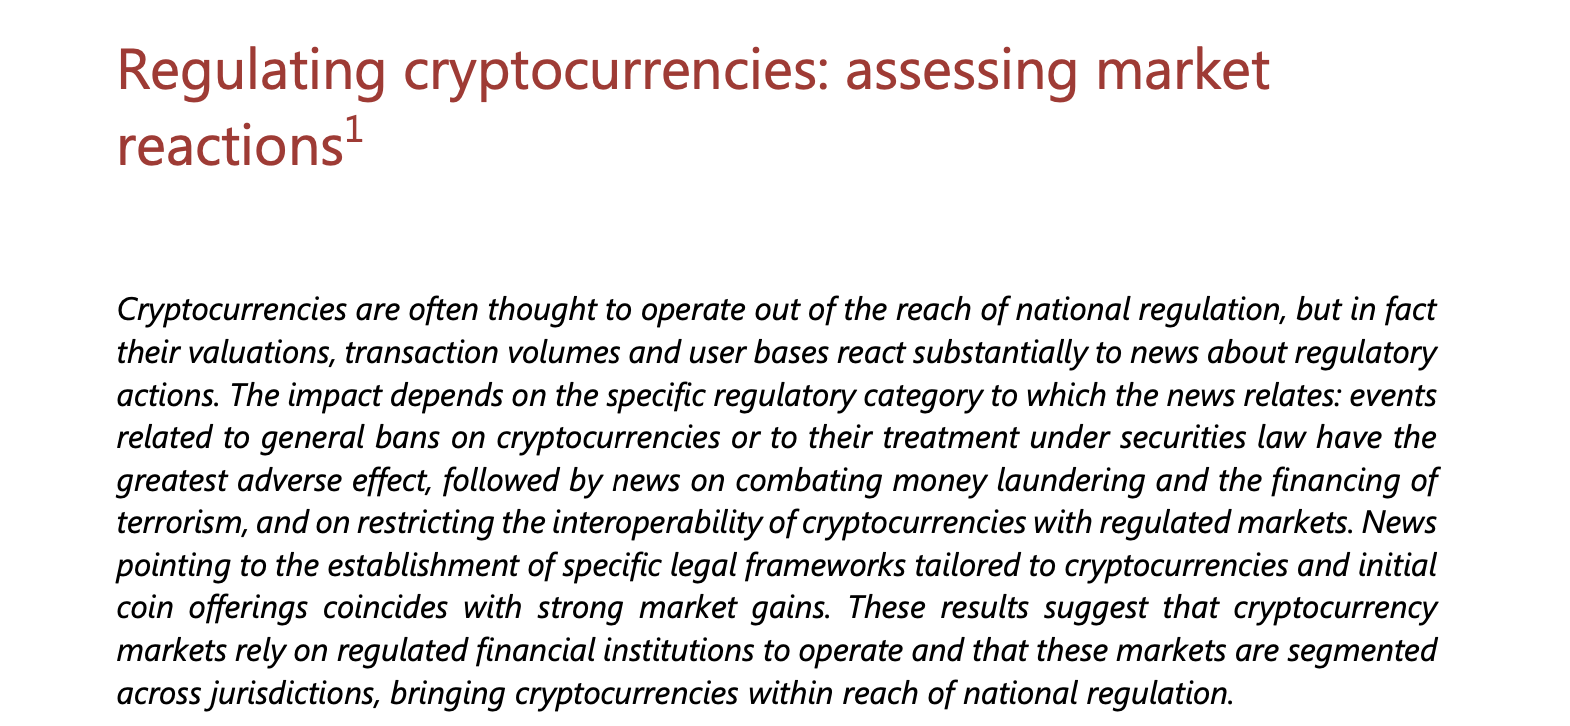

In [119]:
display(Image('images/pb_intro.png',width=800))

However, for this project we will focus on monetary policy announcement. Many articles and websites tackle this subject, analyzing data and showing FOMC impacts on BTC-USD returns and volumes.

## Support functions

In [6]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger(__name__)

In [7]:
# Fonction intermédiaire pour la présentation des résultats

def sharpe_ratio(df, num_period_per_year=365):
    if num_period_per_year is None:
        return np.nan
    else:
        return df.mean() / df.std() * np.sqrt(num_period_per_year)

In [8]:
# Fonction pour charger les données 

def load_bitcoin_daily_prices(ticker = 'BTC-USD', period = 'max'):
    """
    load bitcoin daily prices for Yahoo finance website:
    https://finance.yahoo.com/quote/BTC-USD?p=BTC-USD
    """
    data = yf.Ticker(ticker).history(period = period, interval = '1d')['Close']
    return pd.DataFrame(data)


def load_bitcoin_daily_returns(ticker = 'BTC-USD', period = 'max'):
    """
    load bitcoin daily prices for Yahoo finance website and compute daily returns 
    """
    data = yf.Ticker(ticker).history(period = period, interval = '1d')['Close']
    ret = pd.DataFrame(data.pipe(lambda x : 100*(x - x.shift(1))/x.shift(1)))
    return ret.rename(columns = {'Close':'Return'})

In [9]:
############################
# Charger les données 
############################


daily_returns = load_bitcoin_daily_returns()

daily_returns.index = daily_returns.index.astype("datetime64[ns]") 
daily_returns.loc[daily_returns.index[0]] = 0.0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  


## Announcements dates

### Collect FOMC announcements

In [10]:
#Charger les dates d'annonces 

def bs_cleaner(bs, html_tag_blocked=None): 
    if html_tag_blocked is None: 
        html_tag_blocked = ['style', 'script', '[document]',  'meta',  'a',  'span',  'label', 'strong', 'button', 
                     'li', 'h6',  'font', 'h1', 'h2',  'h3', 'h5', 'h4',  'em', 'body', 'head']
    return [sent_cleaner(t) for t in bs.find_all(text=True) 
            if (t.parent.name not in html_tag_blocked)&(len(sent_cleaner(t))>0)]

def sent_cleaner(s): 
    return s.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').strip() 

def get_fomc_urls(from_year = 1999, switch_year=2017): 
    calendar_url = 'https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm'
    r = requests.get(calendar_url)
    soup = BeautifulSoup(r.text, 'html.parser')
    contents = soup.find_all('a', href=re.compile('^/newsevents/pressreleases/monetary\d{8}[ax].htm'))
    urls_ = [content.attrs['href'] for content in contents]

    for year in range(from_year, switch_year):
        yearly_contents = []
        fomc_yearly_url = f'https://www.federalreserve.gov/monetarypolicy/fomchistorical{year}.htm'
        r_year = requests.get(fomc_yearly_url)
        soup_yearly = BeautifulSoup(r_year.text, 'html.parser')
        yearly_contents = soup_yearly.findAll('a', text='Statement')
        for yearly_content in yearly_contents:
            urls_.append(yearly_content.attrs['href'])
    
    urls = ['https://www.federalreserve.gov' + url for url in urls_]
    return urls 

regexp = re.compile(r'\s+', re.UNICODE)

def feature_extraction(corpus, sent_filters=None):
    if sent_filters is None: 
        sent_filters = ['Board of Governors', 'Federal Reserve System',
                         '20th Street and Constitution Avenue N.W., Washington, DC 20551',
                         'Federal Reserve Board - Federal Reserve issues FOMC statement',
                         'For immediate release',
                         'Federal Reserve Board - FOMC statement',
                         'DO NOT REMOVE:  Wireless Generation',
                         'For media inquiries', 
                         'or call 202-452-2955.',
                         'Voting', 
                         'For release at', 
                         'For immediate release', 
                        'Last Update', 
                        'Last update'
                        ]

    text = [' '.join([regexp.sub(' ', s) for i, s in enumerate(c) 
                     if (i>1) & np.all([q not in s for q in sent_filters])])
            for c in corpus]
    
    release_date = [pd.to_datetime(c[1].replace('Release Date: ', '')) for c in corpus]
    last_update = [pd.to_datetime([s.replace('Last update:', '').replace('Last Update:', '').strip() 
                   for s in c if 'last update: ' in s.lower()][0]) for c in corpus]
    voting = [' '.join([s for s in c if 'Voting' in s]) for c in corpus]
    release_time = [' '.join([s for s in c if ('For release at' in s)|('For immediate release' in s)]) for c in corpus]
    
    return pd.DataFrame({'release_date': release_date, 
                         'last_update':  last_update, 
                         'text': text, 
                         'voting': voting, 
                         'release_time': release_time})


def load_fomc_statements(add_url=True, cache_dir=None, force_reload=False, 
                        progress_bar=True, from_year=1999):
    if cache_dir is None:
        cache_dir = Path(os.getcwd()) / "data"
    if isinstance(cache_dir, str):
        cache_dir = Path(cache_dir)
        
    filename = cache_dir / 'fomc_statements.parquet'
    if (filename.exists()) & (~force_reload):
        logger.info(f"logging from cache file: {filename}")
        statements = pd.read_parquet(filename)
    else: 
        logger.info("loading from external source")
        urls = get_fomc_urls(from_year = from_year)
        if progress_bar: 
            urls_ = tqdm(urls)
        else: 
            urls_ = urls 
        corpus = [bs_cleaner(BeautifulSoup(requests.get(url).text, 'html.parser')) for url in urls_]
        statements = feature_extraction(corpus).set_index('release_date')
        if add_url: 
            statements = statements.assign(url=urls)
        statements= statements.sort_index()
        logger.info(f"saving cache file {filename}")
        #statements.to_parquet(filename)
    return statements

In [120]:
statements = load_fomc_statements(force_reload=False)
statements.head()

INFO:__main__:loading from external source


  0%|          | 0/204 [00:00<?, ?it/s]

INFO:__main__:saving cache file /Users/boubacarsidibe/Documents/MS-DS-ENSAE/ML_Trading/Project_BS/data/fomc_statements.parquet


,last_update,text,voting,release_time,url
release_date,,,,,
1999-05-18,1999-05-18 14:15:00,The Federal Reserve released the following sta...,,,https://www.federalreserve.gov/boarddocs/press...
1999-06-30,1999-06-30 00:00:00,The Federal Open Market Committee today voted ...,,,https://www.federalreserve.gov/boarddocs/press...
1999-08-24,1999-08-24 00:00:00,With financial markets functioning more normal...,,,https://www.federalreserve.gov/boarddocs/press...
1999-10-05,1999-10-05 00:00:00,The Federal Open Market Committee decided toda...,,,https://www.federalreserve.gov/boarddocs/press...
1999-11-16,1999-11-16 00:00:00,Although cost pressures appear generally conta...,,,https://www.federalreserve.gov/boarddocs/press...


## Summary statistics for Bitcoin daily returns

daily_returns['2019-01-01':].describe()

On the period choosen, BTC mean daily return is 0.18\%. The largest daily lost is -37\%, and the largest gain is 19\%. Also, only 25\% of daily return are above 1.75\%.

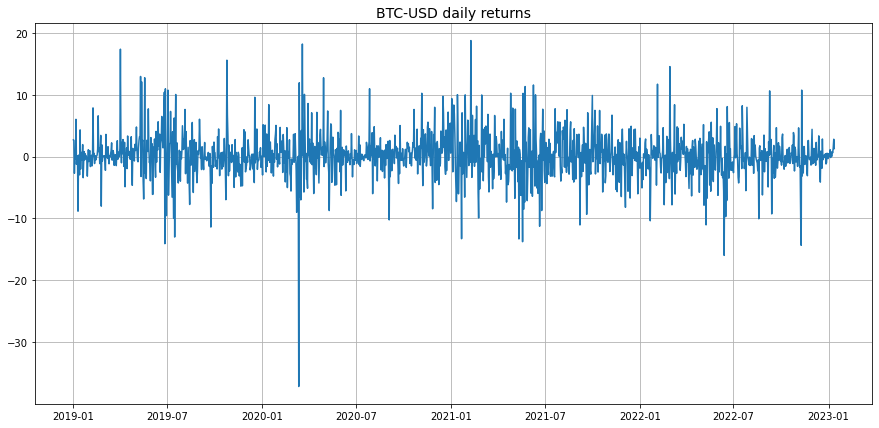

In [154]:
fig, ax = plt.subplots(1,1, figsize = (15,7))
ax.plot(daily_returns['2019-01-01':].index, daily_returns['2019-01-01':].values)
ax.set_title('BTC-USD daily returns', fontsize =14)
ax.grid(True)

On the plot, we can see daily returns oscilliating around 0.

In [14]:
# volumes on annoucements vs non-annoucements days

## Strategy implementation

In [106]:
from_ = '2019-01-01'
returns = daily_returns.loc[from_:]

In [107]:
# index de dates pour les annonces
special_days = ['2020-03-15']
idx = statements[returns.sort_index().index[0]:].index.union(pd.to_datetime(pd.Index(special_days)))


# tableau des rendements 
ret_fomc = pd.concat({'fomc': returns.loc[returns.index.intersection(idx)],
                      'not fomc': returns.loc[returns.index.difference(idx)]}, axis=1)
ret_fomc.head()

,fomc,not fomc
,Return,Return
Date,,
2019-01-01,NaN,2.693766
2019-01-02,NaN,2.598904
2019-01-03,NaN,-2.704974
2019-01-04,NaN,0.546722
2019-01-05,NaN,-0.324621


Text(0.5, 1.0, 'Returns boxplots')

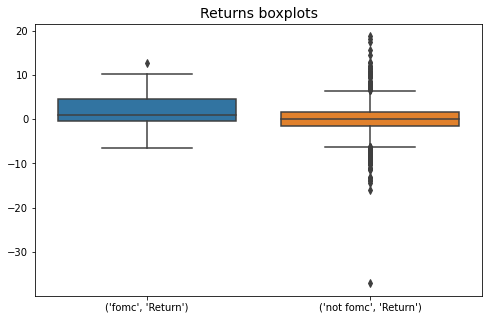

In [153]:
fig, ax = plt.subplots(1, figsize=(8, 5))
sns.boxplot(data = ret_fomc)
ax.set_title('Returns boxplots', fontsize = 14)

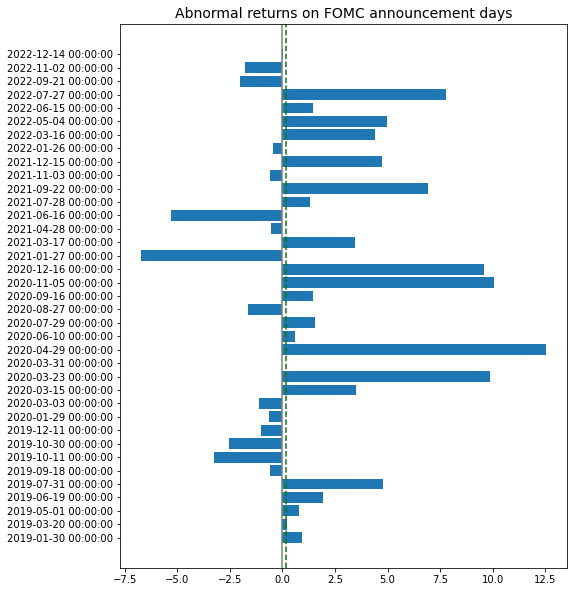

In [128]:
abnorm_ret_fomc = (ret_fomc.loc[ret_fomc.index.intersection(idx)] - np.mean(returns['Return']))['fomc']

fig, ax = plt.subplots(1, 1, figsize=(8,10))
labels = abnorm_ret_fomc.index
x = np.arange(len(labels))
ax.barh(x, abnorm_ret_fomc['Return'].values, capsize=5)
ax.axvline(x=0,color='grey')
ax.axvline(x= np.mean(returns['Return']), color='g', linestyle = '--', label = 'Average return')

ax.set_title('Abnormal returns on FOMC announcement days', fontsize = 14)
u_ = ax.set_yticks(x)
v_ = ax.set_yticklabels(labels, rotation=0)

When plotting abnormal returns, that are daily returns minus the average return on the whole period, on FOMC announcement days we see that they are relatively much higher in absolute, subsequently on some dates. In additon, on the returns boxplots we see that most returns on announcement days are above the third quartile of the returns on non-announcement days.


These observations suggest, and confirm that FOMC announcements indeed have an effect on BTC-USD returns. 

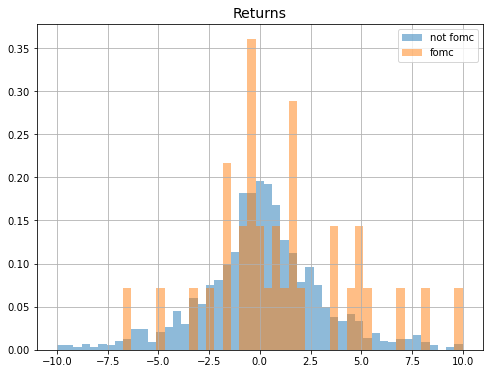

In [155]:
plt.figure(figsize =(8,6))
bins = np.linspace(-10, 10, 50)
plt.hist(ret_fomc['not fomc']['Return'].dropna(), bins, density=True, alpha=0.5, label='not fomc')
plt.hist(ret_fomc['fomc']['Return'].dropna(), bins, density=True, alpha=0.5, label='fomc')
plt.title("Returns", fontsize = 14)
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

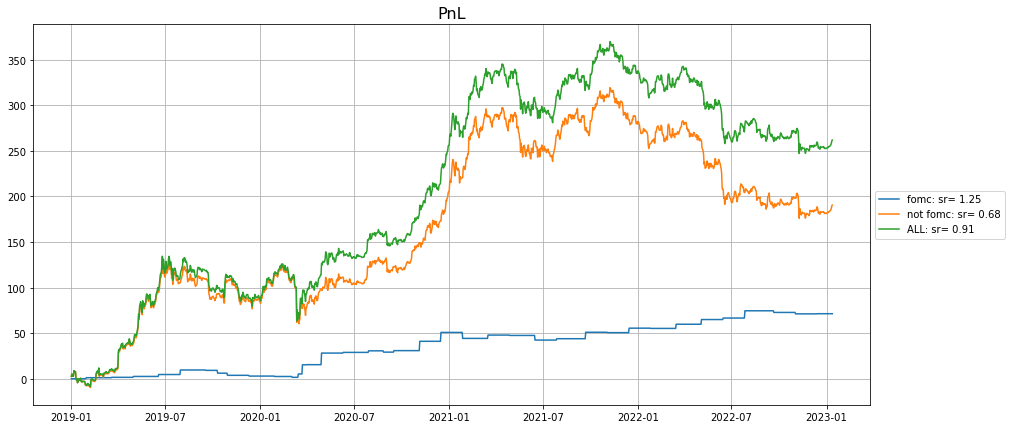

In [158]:
df = ret_fomc.xs('Return', axis=1, level=1).fillna(0).assign(ALL = lambda x: x.sum(axis=1))

fig, ax = plt.subplots(1,1, figsize = (15,7))
df.columns = [f"{c}: sr={sharpe_ratio(df[c]): 3.2f}" for c in df.columns]

ax.plot(df.index, df.cumsum())
ax.legend(df.columns, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("PnL", fontsize = 16)
ax.grid(True)

Between 2019 and 2020, the PnL of our strategy remains flat, near 0. After that it starts growing, with some corrections, but we can see an overall growing trend. We obtain a sharpe ratio of 1.25, which is higher than the sharpe ratio of being long on the whole period or only on non-announcement days, respectively 0.91 and 0.68.

## Adding Sentiment analysis

Now, let's try to add sentiment analysis in this strategy. The goal is to see if FOMC announcements can be used to predict the direction of prices. 

To do so we will analyze FOMC annoucements using the Loughran-Mcdonald dictionary, if the sentiment is positive we will be long bitcoin in annoucement day, if it is negative we will be short. 

In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [112]:
def load_loughran_mcdonald_dictionary(cache_dir=None, force_reload=False, quiet=True): 
    if cache_dir is None:
        cache_dir = Path(os.getcwd()) 
    if isinstance(cache_dir, str):
        cache_dir = Path(cache_dir)
        
    filename = cache_dir / 'Loughran-McDonald_MasterDictionary_1993-2021.csv'
    if (filename.exists()) & (~force_reload):
        logger.info(f"logging from cache file: {filename}")
    else: 
        logger.info("loading from external source")
        url = 'https://drive.google.com/uc?id=17CmUZM9hGUdGYjCXcjQLyybjTrcjrhik'
        output = str(filename)
        gdown.download(url, output, quiet=quiet, fuzzy=True)
        
    return pd.read_csv(filename)

In [113]:
sentiment_dico = load_loughran_mcdonald_dictionary()

INFO:__main__:logging from cache file: /Users/boubacarsidibe/Documents/MS-DS-ENSAE/ML_Trading/Project_BS/Loughran-McDonald_MasterDictionary_1993-2021.csv


In [114]:
# Stockage des texts
texts = statements['text']


#Classification des annonces positives ou negatives
funcs = {'negative': lambda x: x.Negative>0, 'positive': lambda x: x.Positive>0,
         'all': lambda x: x.Word.notna()}
def get_total_count(X, lm, func):
    m = CountVectorizer(vocabulary=lm.loc[func].Word.str.lower().values)
    return pd.DataFrame(m.fit_transform(X).toarray(), index=X.index).sum(axis=1)

sentiment_dico_count = pd.concat({k: get_total_count(texts, sentiment_dico, v) for k, v in funcs.items()},
                          axis=1)[from_:]

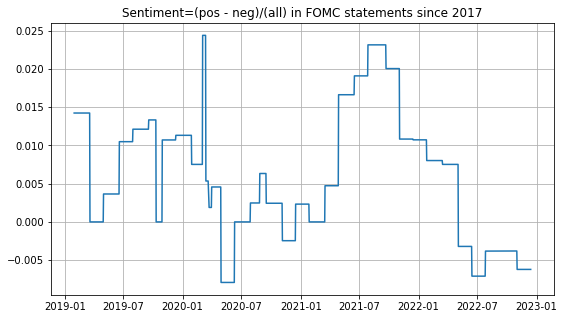

In [159]:
x = sentiment_dico_count.pipe(lambda x:(x.positive-x.negative)/x['all']).resample('B').last().ffill()
plt.figure(figsize = (9,5))
plt.plot(x)
plt.title('Sentiment=(pos - neg)/(all) in FOMC statements since 2017')
plt.grid(True)

In [163]:
sentiment_dico_count['sentiment'] = np.where(sentiment_dico_count['positive'] - sentiment_dico_count['negative']>0, 1, -1)

sentiment_fomc_dates = pd.DataFrame(sentiment_dico_count['sentiment'])
sentiment_fomc_dates.head()

,sentiment
release_date,
2019-01-30,1
2019-03-20,-1
2019-05-01,1
2019-06-19,1
2019-07-31,1


In [164]:
table = pd.concat({'fomc': returns.loc[returns.index.intersection(idx)],
                      'not fomc': returns.loc[returns.index.difference(idx)], 
          'sentiment_fomc': returns.loc[returns.index.intersection(idx)]*sentiment_fomc_dates.loc[returns.index.intersection(idx)].values}, axis=1)

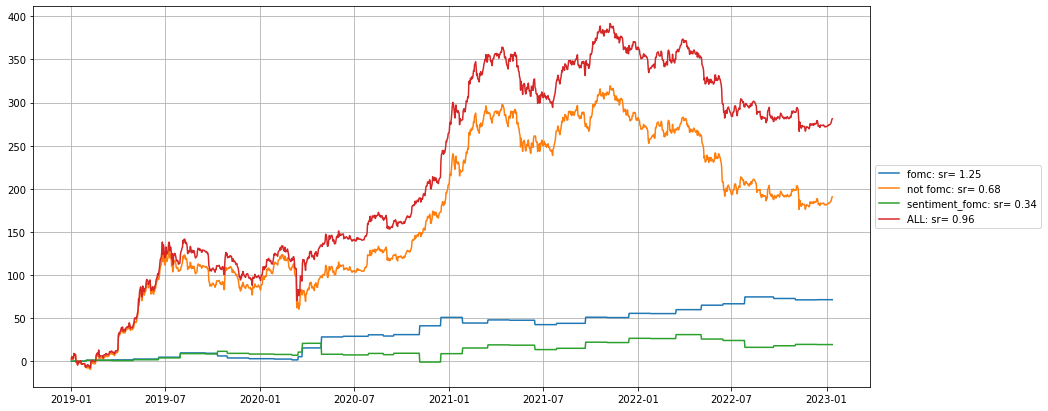

In [165]:
df = table.xs('Return', axis=1, level=1).fillna(0).assign(ALL = lambda x: x.sum(axis=1))

fig, ax = plt.subplots(1,1, figsize = (15,7))
df.columns = [f"{c}: sr={sharpe_ratio(df[c]): 3.2f}" for c in df.columns]

ax.plot(df.index, df.cumsum())
ax.legend(df.columns, loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True)

We see that our sentiment analysis strategy as the lowest sharpe ratio, 0.34. 

We should maybe use another dictionary most suited to cryptocurrencies or similar asset class to obtain a better accuracy on the sentiment given by the FOMC announcements texts.

## Link

In [135]:
'https://newsapi.org/docs/endpoints/everything'

'https://newsapi.org/docs/endpoints/everything'